In [170]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib._color_data as mcd
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
%matplotlib inline

In [2]:
#load Amfar opioid and HIV data, add county code
opiod_df = pd.read_table('data/amfAR/countydata.tsv',header=0)
opiod_df['county_code'] = opiod_df.STATEFP*1000 + opiod_df.COUNTYFP # build a county code column
opiod_df['county_code'] = opiod_df.county_code.astype(int)

In [3]:
opiod_df.head()

,STATEFP,COUNTYFP,YEAR,INDICATOR,VALUE,COUNTY,STATE,STATEABBREVIATION,county_code
0,1,1,2017,bup_phys,2.0,Autauga County,Alabama,AL,1001
1,1,3,2017,bup_phys,13.0,Baldwin County,Alabama,AL,1003
2,1,5,2017,bup_phys,0.0,Barbour County,Alabama,AL,1005
3,1,7,2017,bup_phys,0.0,Bibb County,Alabama,AL,1007
4,1,9,2017,bup_phys,1.0,Blount County,Alabama,AL,1009


In [4]:
#make changes to the amfar dataframe
#convert from long to wide format
index_lst = ['county_code', 'COUNTY', 'STATEABBREVIATION', 'YEAR']
col_lst = ['INDICATOR']
opiod_df_wide = opiod_df.pivot_table(values='VALUE', index=index_lst, columns=col_lst).reset_index()

In [5]:
opiod_df_wide.head()

INDICATOR,county_code,COUNTY,STATEABBREVIATION,YEAR,AMAT_fac,CDC_consult,HIVdiagnoses,HIVincidence,HIVprevalence,MH_fac,...,drugdeathrate_est,drugdeaths,drugdep,mme_percap,nonmedpain,num_SSPs,partD30dayrxrate,pctunins,pctunmetneed,vulnerable_rank
0,1001,Autauga County,AL,1999,NaN,NaN,NaN,NaN,NaN,NaN,...,2.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1001,Autauga County,AL,2000,NaN,NaN,NaN,NaN,NaN,NaN,...,4.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1001,Autauga County,AL,2001,NaN,NaN,NaN,NaN,NaN,NaN,...,4.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1001,Autauga County,AL,2002,NaN,NaN,NaN,NaN,NaN,NaN,...,4.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1001,Autauga County,AL,2003,NaN,NaN,NaN,NaN,NaN,NaN,...,4.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Focus on just the HIV related data, from 2008 onward
opiod_df_wide = opiod_df_wide[opiod_df_wide['YEAR'] >= 2008] # subset for years that have hiv data
cols_to_drop = ['CDC_consult', 'vulnerable_rank']
#, 'num_SSPs', 'bup_phys', 'drugdep', 'pctunmetneed', 'nonmedpain']
opiod_df_wide.drop(cols_to_drop, axis=1, inplace=True) # drop unnecessary columns

In [7]:
opiod_df_wide.head()

INDICATOR,county_code,COUNTY,STATEABBREVIATION,YEAR,AMAT_fac,HIVdiagnoses,HIVincidence,HIVprevalence,MH_fac,Med_AMAT_fac,...,drugdeathrate,drugdeathrate_est,drugdeaths,drugdep,mme_percap,nonmedpain,num_SSPs,partD30dayrxrate,pctunins,pctunmetneed
9,1001,Autauga County,AL,2008,0.0,8.0,19.8,NaN,NaN,0.0,...,NaN,6.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,1001,Autauga County,AL,2009,0.0,7.0,17.1,NaN,NaN,0.0,...,NaN,6.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,1001,Autauga County,AL,2010,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,8.1,NaN,NaN,1050.8,NaN,NaN,NaN,NaN,NaN
12,1001,Autauga County,AL,2011,0.0,7.0,15.5,NaN,NaN,0.0,...,NaN,8.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,1001,Autauga County,AL,2012,0.0,7.0,15.5,NaN,NaN,0.0,...,NaN,8.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
fill_nan_cols = ['HIVdiagnoses', 'HIVincidence', 'HIVprevalence',
                 'PLHIV', 'drugdeathrate', 'drugdeaths']
opiod_df_wide[fill_nan_cols] = opiod_df_wide[fill_nan_cols].fillna(0) #fill NaNs for suppressed data with zeroes

In [9]:
opiod_df_wide.head()

INDICATOR,county_code,COUNTY,STATEABBREVIATION,YEAR,AMAT_fac,HIVdiagnoses,HIVincidence,HIVprevalence,MH_fac,Med_AMAT_fac,...,drugdeathrate,drugdeathrate_est,drugdeaths,drugdep,mme_percap,nonmedpain,num_SSPs,partD30dayrxrate,pctunins,pctunmetneed
9,1001,Autauga County,AL,2008,0.0,8.0,19.8,0.0,NaN,0.0,...,0.0,6.1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,1001,Autauga County,AL,2009,0.0,7.0,17.1,0.0,NaN,0.0,...,0.0,6.1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,1001,Autauga County,AL,2010,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,8.1,0.0,NaN,1050.8,NaN,NaN,NaN,NaN,NaN
12,1001,Autauga County,AL,2011,0.0,7.0,15.5,0.0,NaN,0.0,...,0.0,8.1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,1001,Autauga County,AL,2012,0.0,7.0,15.5,0.0,NaN,0.0,...,0.0,8.1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Subset data to 2015
opiod_df_15 = opiod_df_wide[opiod_df_wide['YEAR'] == 2015]

In [11]:
opiod_df_15.head()

INDICATOR,county_code,COUNTY,STATEABBREVIATION,YEAR,AMAT_fac,HIVdiagnoses,HIVincidence,HIVprevalence,MH_fac,Med_AMAT_fac,...,drugdeathrate,drugdeathrate_est,drugdeaths,drugdep,mme_percap,nonmedpain,num_SSPs,partD30dayrxrate,pctunins,pctunmetneed
16,1001,Autauga County,AL,2015,0.0,5.0,10.9,225.5,1.0,0.0,...,0.0,10.1,0.0,NaN,1084.0,NaN,NaN,2.34,10.1,NaN
35,1003,Baldwin County,AL,2015,0.0,15.0,8.7,163.9,4.0,0.0,...,21.1,20.1,43.0,NaN,1148.5,NaN,NaN,2.56,13.0,NaN
54,1005,Barbour County,AL,2015,0.0,0.0,0.0,436.0,1.0,0.0,...,0.0,6.1,0.0,NaN,577.6,NaN,NaN,1.46,15.5,NaN
73,1007,Bibb County,AL,2015,0.0,0.0,0.0,191.9,0.0,0.0,...,0.0,14.1,0.0,NaN,563.0,NaN,NaN,0.39,9.7,NaN
92,1009,Blount County,AL,2015,0.0,5.0,10.4,95.4,1.0,0.0,...,0.0,16.1,11.0,NaN,459.0,NaN,NaN,1.22,11.6,NaN


In [12]:
pd.options.mode.chained_assignment = None  # default='warn', get rid of annoying warning associated with dropping below
# drop columns having no 2015 data, will be extraploated from following years later
opiod_df_15.drop(['num_SSPs', 'bup_phys', 'drugdep', 'pctunmetneed', 'nonmedpain'], axis=1, inplace=True)

In [13]:
opiod_df_15.head()

INDICATOR,county_code,COUNTY,STATEABBREVIATION,YEAR,AMAT_fac,HIVdiagnoses,HIVincidence,HIVprevalence,MH_fac,Med_AMAT_fac,...,Population,SA_fac,SMAT_fac,TMAT_fac,drugdeathrate,drugdeathrate_est,drugdeaths,mme_percap,partD30dayrxrate,pctunins
16,1001,Autauga County,AL,2015,0.0,5.0,10.9,225.5,1.0,0.0,...,55035.0,2.0,0.0,0.0,0.0,10.1,0.0,1084.0,2.34,10.1
35,1003,Baldwin County,AL,2015,0.0,15.0,8.7,163.9,4.0,0.0,...,203690.0,2.0,0.0,0.0,21.1,20.1,43.0,1148.5,2.56,13.0
54,1005,Barbour County,AL,2015,0.0,0.0,0.0,436.0,1.0,0.0,...,26270.0,1.0,0.0,0.0,0.0,6.1,0.0,577.6,1.46,15.5
73,1007,Bibb County,AL,2015,0.0,0.0,0.0,191.9,0.0,0.0,...,22561.0,1.0,1.0,0.0,0.0,14.1,0.0,563.0,0.39,9.7
92,1009,Blount County,AL,2015,0.0,5.0,10.4,95.4,1.0,0.0,...,57676.0,1.0,0.0,0.0,0.0,16.1,11.0,459.0,1.22,11.6


In [14]:
# get esimates for num_SSPs, bug_phys, drug_dep, pctunmetneed, and nonmedpain from following years

#subset opioid related data from one year only
#number of needle exchange programs (num_SSPs)
opiod_df_wide_17 = opiod_df_wide[opiod_df_wide['YEAR'] == 2017]
df_num_SSP = opiod_df_wide_17[['num_SSPs', 'county_code']]

#number of doctors licensed to rx Buprenorphine (bup_phys)
df_bup_phys = opiod_df_wide_17[['bup_phys', 'county_code']]

#percent with drug dependency (drug_dep)
opiod_df_wide_16 = opiod_df_wide[opiod_df_wide['YEAR'] == 2016]
df_drugdep = opiod_df_wide_16[['drugdep', 'county_code']]

#percent unmet drug treatment need (pctunmetneed)
df_pctunmetneed = opiod_df_wide_16[['pctunmetneed', 'county_code']]

#percent taken pain meds for nonmedical use (nonmedpain)
df_nonmedpain = opiod_df_wide_16[['nonmedpain', 'county_code']]

In [15]:
# merge these values back into 2015 dataframe
#merge opioid related data back to the 2015 dataframe
opiod_df_15 = opiod_df_15.merge(df_num_SSP, on='county_code')
opiod_df_15 = opiod_df_15.merge(df_bup_phys, on='county_code')
opiod_df_15 = opiod_df_15.merge(df_drugdep, on='county_code')
opiod_df_15 = opiod_df_15.merge(df_pctunmetneed, on='county_code')
opiod_df_15 = opiod_df_15.merge(df_nonmedpain, on='county_code')

In [16]:
opiod_df_15.head()

INDICATOR,county_code,COUNTY,STATEABBREVIATION,YEAR,AMAT_fac,HIVdiagnoses,HIVincidence,HIVprevalence,MH_fac,Med_AMAT_fac,...,drugdeathrate_est,drugdeaths,mme_percap,partD30dayrxrate,pctunins,num_SSPs,bup_phys,drugdep,pctunmetneed,nonmedpain
0,1001,Autauga County,AL,2015,0.0,5.0,10.9,225.5,1.0,0.0,...,10.1,0.0,1084.0,2.34,10.1,0.0,2.0,2.56,95.70,5.12
1,1003,Baldwin County,AL,2015,0.0,15.0,8.7,163.9,4.0,0.0,...,20.1,43.0,1148.5,2.56,13.0,0.0,13.0,2.54,91.34,5.27
2,1005,Barbour County,AL,2015,0.0,0.0,0.0,436.0,1.0,0.0,...,6.1,0.0,577.6,1.46,15.5,0.0,0.0,2.54,91.34,5.27
3,1007,Bibb County,AL,2015,0.0,0.0,0.0,191.9,0.0,0.0,...,14.1,0.0,563.0,0.39,9.7,0.0,0.0,2.58,91.86,5.62
4,1009,Blount County,AL,2015,0.0,5.0,10.4,95.4,1.0,0.0,...,16.1,11.0,459.0,1.22,11.6,0.0,1.0,2.58,91.86,5.62


In [17]:
#load Men who have sex with men (MSM) estimate data
msm_df = pd.read_csv("data/CAMP/US_MSM_Estimates_Data_2013.csv")    #load the data
msm_df['county_code'] = msm_df.STATEFP*1000 + msm_df.COUNTYFP  # build a county code column
msm_df['county_code'] = msm_df.county_code.astype(int)
msm_df['%msm12month'] = 100 * (msm_df.MSM12MTH / msm_df.ADULTMEN) # build a %MSM within last 12 months column
msm_df['%msm5yr'] = 100 * (msm_df.MSM5YEAR / msm_df.ADULTMEN)     # build a %MSM within last 5years column

In [18]:
msm_df.head()

,REGCODE,DIVCODE,STATEFP,COUNTYFP,CSACODE,CBSACODE,METDCODE,METMICSA,CENTOUTL,ADULTMEN,MSM12MTH,MSM5YEAR,county_code,%msm12month,%msm5yr
0,3,6,1,1,NaN,33860.0,NaN,1.0,NaN,19410,333,514,1001,1.715611,2.648120
1,3,6,1,3,380.0,19300.0,NaN,1.0,1.0,69724,925,1429,1003,1.326659,2.049509
2,3,6,1,5,NaN,NaN,NaN,NaN,NaN,11567,82,127,1005,0.708913,1.097951
3,3,6,1,7,142.0,13820.0,NaN,1.0,2.0,9508,119,184,1007,1.251578,1.935212
4,3,6,1,9,142.0,13820.0,NaN,1.0,2.0,21368,601,928,1009,2.812617,4.342943


In [19]:
cols_to_drop = ['REGCODE', 'DIVCODE', 'STATEFP', 'COUNTYFP', 'CSACODE', 
                'CBSACODE','METDCODE', 'METMICSA', 'CENTOUTL']
msm_df.drop(cols_to_drop, axis=1, inplace=True) #drop all unneeded columns
msm_df.head()

,ADULTMEN,MSM12MTH,MSM5YEAR,county_code,%msm12month,%msm5yr
0,19410,333,514,1001,1.715611,2.648120
1,69724,925,1429,1003,1.326659,2.049509
2,11567,82,127,1005,0.708913,1.097951
3,9508,119,184,1007,1.251578,1.935212
4,21368,601,928,1009,2.812617,4.342943


In [20]:
#unemplyment data
df_employment = pd.read_csv("data/ACS_14_5YR_employment/ACS_14_5YR_S2301_with_ann.csv", 
                            encoding = "ISO-8859-1", skiprows=1)
df_employment = df_employment[['Id2', 'Unemployment rate; Estimate; Population 16 years and over']]
df_employment.columns = ['county_code', 'unemployment_rate']
df_employment.head()

,county_code,unemployment_rate
0,1001,8.5
1,1003,8.6
2,1005,14.2
3,1007,10.9
4,1009,9.3


In [21]:
#poverty data
df_poverty = pd.read_csv("data/ACS_14_5YR_poverty/ACS_14_5YR_S1701_with_ann.csv", 
                         encoding = "ISO-8859-1", skiprows=1)
df_poverty = df_poverty[['Id2', 'Percent below poverty level; Estimate; Population for whom poverty status is determined']]
df_poverty.columns = ['county_code', 'poverty_rate']
df_poverty.head()

,county_code,poverty_rate
0,1001,12.8
1,1003,13.8
2,1005,24.1
3,1007,17.0
4,1009,17.3


In [22]:
#income data
df_income = pd.read_csv("data/ACS_14_5YR_income/ACS_14_5YR_S1901_with_ann.csv", 
                        encoding = "ISO-8859-1", skiprows=1)
df_income = df_income[['Id2', 'Households; Estimate; Total']]
df_income.columns = ['county_code', 'household_income']
df_income.head()

,county_code,household_income
0,1001,20304
1,1003,73058
2,1005,9145
3,1007,7078
4,1009,20934


In [62]:
#merge asfAR hiv/opioid data with CAMP MSM data
df_main = opiod_df_15.merge(msm_df, on='county_code')

#merge in ACS data
df_main = df_main.merge(df_employment, on='county_code')
df_main = df_main.merge(df_poverty, on='county_code')
df_main = df_main.merge(df_income, on='county_code')

df_main.info()

In [216]:

# Get names of indexes for which column Age has value 30
indexNames = df_main[df_main['COUNTY'] == "Scott County"]
# Delete these row indexes from dataFrame
#dfObj.drop(indexNames , inplace=True)琀
df_main = df_main[df_main['county_code'] != 18143]
df_main = df_main[df_main['HIVincidence'] > 0]


In [217]:
df_main

,county_code,COUNTY,STATEABBREVIATION,YEAR,AMAT_fac,HIVdiagnoses,HIVincidence,HIVprevalence,MH_fac,Med_AMAT_fac,...,pctunmetneed,nonmedpain,ADULTMEN,MSM12MTH,MSM5YEAR,%msm12month,%msm5yr,unemployment_rate,poverty_rate,household_income
0,1001,Autauga County,AL,2015,0.0,5.0,10.9,225.5,1.0,0.0,...,95.70,5.12,19410,333,514,1.715611,2.648120,8.5,12.8,20304
1,1003,Baldwin County,AL,2015,0.0,15.0,8.7,163.9,4.0,0.0,...,91.34,5.27,69724,925,1429,1.326659,2.049509,8.6,13.8,73058
4,1009,Blount County,AL,2015,0.0,5.0,10.4,95.4,1.0,0.0,...,91.86,5.62,21368,601,928,2.812617,4.342943,9.3,17.3,20934
5,1011,Bullock County,AL,2015,0.0,8.0,90.7,691.4,0.0,0.0,...,95.70,5.12,4597,73,113,1.587992,2.458125,17.4,20.5,3746
7,1015,Calhoun County,AL,2015,0.0,10.0,10.3,211.2,5.0,0.0,...,91.86,5.62,43018,692,1070,1.608629,2.487331,13.5,21.7,45348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3085,55079,Milwaukee County,WI,2015,0.0,120.0,15.3,357.8,57.0,0.0,...,91.61,5.02,339381,11921,18428,3.512571,5.429886,10.5,21.9,381446
3089,55087,Outagamie County,WI,2015,0.0,5.0,3.3,61.2,11.0,0.0,...,86.44,4.08,66051,817,1263,1.236923,1.912159,4.8,8.9,70144
3096,55101,Racine County,WI,2015,0.0,8.0,4.9,125.1,11.0,0.0,...,88.57,4.35,72170,697,1078,0.965775,1.493695,9.4,13.3,75078
3098,55105,Rock County,WI,2015,0.0,8.0,6.0,100.5,18.0,0.0,...,91.45,4.30,58669,1141,1764,1.944809,3.006699,9.4,14.9,63385


In [218]:
df2 = df_main.dropna(axis=0, how='any')
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 746 entries, 0 to 3112
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   county_code        746 non-null    int64  
 1   COUNTY             746 non-null    object 
 2   STATEABBREVIATION  746 non-null    object 
 3   YEAR               746 non-null    int64  
 4   AMAT_fac           746 non-null    float64
 5   HIVdiagnoses       746 non-null    float64
 6   HIVincidence       746 non-null    float64
 7   HIVprevalence      746 non-null    float64
 8   MH_fac             746 non-null    float64
 9   Med_AMAT_fac       746 non-null    float64
 10  Med_MH_fac         746 non-null    float64
 11  Med_SA_fac         746 non-null    float64
 12  Med_SMAT_fac       746 non-null    float64
 13  Med_TMAT_fac       746 non-null    float64
 14  PLHIV              746 non-null    float64
 15  Population         746 non-null    float64
 16  SA_fac             746 no

In [219]:

county_index = df2[['HIVincidence', 'COUNTY','STATEABBREVIATION', 'YEAR']]
y = df2['HIVincidence']
X = df2.drop(['HIVincidence', 'COUNTY','STATEABBREVIATION', 'YEAR', 'partD30dayrxrate', 'pctunmetneed', 'nonmedpain'], axis=1)

In [220]:
X = sm.add_constant(X)

,const,county_code,AMAT_fac,HIVdiagnoses,HIVprevalence,MH_fac,Med_AMAT_fac,Med_MH_fac,Med_SA_fac,Med_SMAT_fac,...,num_SSPs,bup_phys,ADULTMEN,MSM12MTH,MSM5YEAR,%msm12month,%msm5yr,unemployment_rate,poverty_rate,household_income
0,1.0,1001,0.0,5.0,225.5,1.0,0.0,1.0,2.0,0.0,...,0.0,2.0,19410,333,514,1.715611,2.648120,8.5,12.8,20304
1,1.0,1003,0.0,15.0,163.9,4.0,0.0,3.0,1.0,0.0,...,0.0,13.0,69724,925,1429,1.326659,2.049509,8.6,13.8,73058
2,1.0,1005,0.0,0.0,436.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,11567,82,127,0.708913,1.097951,14.2,24.1,9145
3,1.0,1007,0.0,0.0,191.9,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,9508,119,184,1.251578,1.935212,10.9,17.0,7078
4,1.0,1009,0.0,5.0,95.4,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,21368,601,928,2.812617,4.342943,9.3,17.3,20934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,1.0,56037,0.0,0.0,86.5,3.0,0.0,3.0,5.0,1.0,...,0.0,2.0,16941,177,274,1.044803,1.617378,5.6,12.2,16687
3136,1.0,56039,0.0,0.0,50.5,2.0,0.0,2.0,1.0,0.0,...,0.0,2.0,9172,50,78,0.545137,0.850414,3.6,8.5,7873
3137,1.0,56041,0.0,0.0,0.0,4.0,0.0,4.0,1.0,0.0,...,0.0,2.0,7401,75,116,1.013377,1.567356,5.8,14.2,7557
3138,1.0,56043,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,3141,17,27,0.541229,0.859599,7.9,14.2,3461


In [221]:
reg  = sm.OLS(y, X)
reg = reg.fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           HIVincidence   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     49.83
Date:                Fri, 31 Jul 2020   Prob (F-statistic):          4.75e-156
Time:                        16:59:16   Log-Likelihood:                -2547.6
No. Observations:                 746   AIC:                             5159.
Df Residuals:                     714   BIC:                             5307.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.2296      2.968      0.414      0.679      -4.598       7.057
county_code        2.442e-05   1.89e-05      1.289      0.198   -1.28e-05    6.16e-05
AMAT_fac             -0.4689      1.056     -0.444      0.657      -2.542       1.604
HIVdiagnoses          0.1102      0.011     10.264      0.000       0.089       0.131
HIVprevalence         0.0304      0.002     19.352      0.000       0.027       0.034
MH_fac                0.3282      0.211      1.555      0.120      -0.086       0.743
Med_AMAT_fac          0.4247      1.180      0.360      0.719      -1.893       2.742
Med_MH_fac           -0.2220      0.231     -0.963      0.336      -0.675       0.231
Med_SA_fac           -0.1705      0.138     -1.239      0.216      -0.441       0.100
Med_SMAT_fac          0.2641      0.416      0.635      0.526      -0.553       1.081
Med_TMAT_fac         -0.0772      0.599     -0.129      0.897      -1.252       1.098
PLHIV                -0.0036      0.000     -8.594      0.000      -0.004      -0.003
Population        -1.061e-05   1.34e-05     -0.791      0.429   -3.69e-05    1.57e-05
SA_fac                0.0298      0.073      0.407      0.684      -0.114       0.173
SMAT_fac             -0.3033      0.330     -0.920      0.358      -0.951       0.344
TMAT_fac              0.2412      0.457      0.528      0.598      -0.656       1.139
drugdeathrate        -0.1638      0.035     -4.746      0.000      -0.231      -0.096
drugdeathrate_est     0.0129      0.071      0.181      0.857      -0.127       0.153
drugdeaths            0.0051      0.010      0.489      0.625      -0.015       0.026
mme_percap           -0.0028      0.001     -2.892      0.004      -0.005      -0.001
pctunins              0.2267      0.087      2.613      0.009       0.056       0.397
num_SSPs             -0.9199      0.513     -1.795      0.073      -1.926       0.086
bup_phys              0.0421      0.018      2.383      0.017       0.007       0.077
drugdep               0.5769      0.865      0.667      0.505      -1.121       2.275
ADULTMEN          -1.522e-05      4e-05     -0.381      0.703   -9.37e-05    6.32e-05
MSM12MTH              1.5837      1.110      1.427      0.154      -0.596       3.763
MSM5YEAR             -1.0243      0.718     -1.426      0.154      -2.434       0.385
%msm12month        -528.8286    255.106     -2.073      0.039   -1029.677     -27.980
%msm5yr             341.8966    165.024      2.072      0.039      17.906     665.887
unemployment_rate     0.2184      0.133      1.648      0.100      -0.042       0.479
poverty_rate          0.1951      0.074      2.635      0.009       0.050       0.341
household_income   8.311e-06   2.31e-05      0.360      0.719   -3.71e-05    5.37e-05
=========================================================================

In [102]:
feature_lst = [x for x in X.columns]

In [222]:
df2 = sm.add_constant(X)
feat_drop1 = ['const',
 'AMAT_fac',
 'HIVdiagnoses',
 'HIVprevalence',
 'MH_fac',
 'Med_AMAT_fac',
 'Med_MH_fac',
 'Med_SA_fac',
 'Med_SMAT_fac',
 'Med_TMAT_fac',
 'PLHIV',
 'SA_fac',
 'SMAT_fac',
 'TMAT_fac',
 'drugdeathrate',
 'drugdeathrate_est',
 'drugdeaths',
 'num_SSPs',
 'bup_phys',
 'ADULTMEN',
 'MSM12MTH',
 'MSM5YEAR',
 'unemployment_rate',
 'poverty_rate',
 'household_income']

In [223]:
X2 = df2[feat_drop1]

In [224]:
reg  = sm.OLS(y, X2)
reg = reg.fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           HIVincidence   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     61.94
Date:                Fri, 31 Jul 2020   Prob (F-statistic):          3.32e-157
Time:                        16:59:29   Log-Likelihood:                -2559.8
No. Observations:                 746   AIC:                             5170.
Df Residuals:                     721   BIC:                             5285.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.4463      1.350      2.553      0.011       0.796       6.096
AMAT_fac             -0.3577      1.057     -0.339      0.735      -2.432       1.717
HIVdiagnoses          0.1121      0.011     10.379      0.000       0.091       0.133
HIVprevalence         0.0309      0.001     20.652      0.000       0.028       0.034
MH_fac                0.3138      0.210      1.497      0.135      -0.098       0.725
Med_AMAT_fac          0.3189      1.182      0.270      0.787      -2.001       2.639
Med_MH_fac           -0.2252      0.231     -0.974      0.330      -0.679       0.229
Med_SA_fac           -0.1631      0.135     -1.204      0.229      -0.429       0.103
Med_SMAT_fac          0.2965      0.411      0.721      0.471      -0.510       1.103
Med_TMAT_fac         -0.1832      0.601     -0.305      0.761      -1.363       0.996
PLHIV                -0.0036      0.000     -8.713      0.000      -0.004      -0.003
SA_fac                0.0249      0.069      0.360      0.719      -0.111       0.161
SMAT_fac             -0.3006      0.327     -0.918      0.359      -0.943       0.342
TMAT_fac              0.2531      0.461      0.549      0.583      -0.653       1.159
drugdeathrate        -0.1891      0.034     -5.612      0.000      -0.255      -0.123
drugdeathrate_est    -0.0257      0.063     -0.405      0.686      -0.150       0.099
drugdeaths            0.0076      0.010      0.742      0.458      -0.013       0.028
num_SSPs             -0.7019      0.501     -1.401      0.162      -1.686       0.282
bup_phys              0.0431      0.017      2.524      0.012       0.010       0.077
ADULTMEN           -3.23e-05   1.97e-05     -1.642      0.101   -7.09e-05    6.32e-06
MSM12MTH             -0.0777      0.808     -0.096      0.923      -1.665       1.509
MSM5YEAR              0.0504      0.523      0.096      0.923      -0.976       1.077
unemployment_rate     0.1645      0.129      1.276      0.202      -0.089       0.418
poverty_rate          0.2870      0.062      4.648      0.000       0.166       0.408
household_income  -2.608e-06   2.21e-05     -0.118      0.906   -4.61e-05    4.09e-05
==============================================================================
Omnibus:                      473.253   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12616.779
Skew:                           2.387   Prob(JB):                         0.00
Kurtosis:                      22.573   Cond. No.                     1.94e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.94e+06. This might indicate that there are
strong multicollin

In [225]:
'''
'MH_fac',
'Med_AMAT_fac',
'Med_MH_fac',
'Med_SA_fac',
'Med_SMAT_fac',
'Med_TMAT_fac',
'SMAT_fac',
'TMAT_fac',
'AMAT_fac',
 'bup_phys',
 'ADULTMEN',
 'MSM12MTH',
 'MSM5YEAR',
'''


feat_drop2 = ['const',
 'Population',
 'HIVdiagnoses',
 'HIVprevalence',
 'bup_phys',
 'PLHIV',
 'num_SSPs',
 'mme_percap',
 'poverty_rate']
X3 = df2[feat_drop2]

In [226]:
reg  = sm.OLS(y, X3)
reg = reg.fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           HIVincidence   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     170.8
Date:                Fri, 31 Jul 2020   Prob (F-statistic):          3.58e-162
Time:                        16:59:35   Log-Likelihood:                -2586.1
No. Observations:                 746   AIC:                             5190.
Df Residuals:                     737   BIC:                             5232.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.5424      1.107      2.297      0.022       0.369       4.716
Population    -7.454e-06   1.46e-06     -5.116      0.000   -1.03e-05   -4.59e-06
HIVdiagnoses      0.1030      0.009     10.907      0.000       0.084       0.121
HIVprevalence     0.0308      0.001     20.981      0.000       0.028       0.034
bup_phys          0.0197      0.013      1.547      0.122      -0.005       0.045
PLHIV            -0.0032      0.000     -9.033      0.000      -0.004      -0.003
num_SSPs         -1.0248      0.488     -2.102      0.036      -1.982      -0.068
mme_percap       -0.0035      0.001     -4.150      0.000      -0.005      -0.002
poverty_rate      0.4486      0.051      8.878      0.000       0.349       0.548
==============================================================================
Omnibus:                      498.652   Durbin-Watson:                   1.804
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12860.694
Skew:                           2.594   Prob(JB):                         0.00
Kurtosis:                      22.668   Cond. No.                     2.72e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.72e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [227]:
X4

,const,Population,HIVdiagnoses,HIVprevalence,bup_phys,PLHIV,num_SSPs,poverty_rate,y_hat
0,1.0,55035.0,5.0,225.5,2.0,103.0,0.0,12.8,7.657045
1,1.0,203690.0,15.0,163.9,13.0,282.0,0.0,13.8,4.689935
2,1.0,26270.0,0.0,436.0,0.0,97.0,0.0,24.1,13.142384
3,1.0,22561.0,0.0,191.9,0.0,37.0,0.0,17.0,5.334815
4,1.0,57676.0,5.0,95.4,1.0,46.0,0.0,17.3,2.360000
...,...,...,...,...,...,...,...,...,...
3135,1.0,44693.0,0.0,86.5,2.0,31.0,0.0,12.2,1.804624
3136,1.0,23073.0,0.0,50.5,2.0,10.0,0.0,8.5,1.519607
3137,1.0,20819.0,0.0,0.0,2.0,0.0,0.0,14.2,-1.139596
3138,1.0,8334.0,0.0,0.0,0.0,0.0,0.0,14.2,-1.115623


In [228]:
y

0       10.9
1        8.7
4       10.4
5       90.7
7       10.3
        ... 
3085    15.3
3089     3.3
3096     4.9
3098     6.0
3112     1.5
Name: HIVincidence, Length: 746, dtype: float64

In [188]:
X2

,const,AMAT_fac,HIVdiagnoses,HIVprevalence,MH_fac,Med_AMAT_fac,Med_MH_fac,Med_SA_fac,Med_SMAT_fac,Med_TMAT_fac,...,drugdeathrate_est,drugdeaths,num_SSPs,bup_phys,ADULTMEN,MSM12MTH,MSM5YEAR,unemployment_rate,poverty_rate,household_income
0,1.0,0.0,5.0,225.5,1.0,0.0,1.0,2.0,0.0,0.0,...,10.1,0.0,0.0,2.0,19410,333,514,8.5,12.8,20304
1,1.0,0.0,15.0,163.9,4.0,0.0,3.0,1.0,0.0,0.0,...,20.1,43.0,0.0,13.0,69724,925,1429,8.6,13.8,73058
2,1.0,0.0,0.0,436.0,1.0,0.0,1.0,1.0,0.0,0.0,...,6.1,0.0,0.0,0.0,11567,82,127,14.2,24.1,9145
3,1.0,0.0,0.0,191.9,0.0,0.0,0.0,1.0,1.0,0.0,...,14.1,0.0,0.0,0.0,9508,119,184,10.9,17.0,7078
4,1.0,0.0,5.0,95.4,1.0,0.0,1.0,1.0,0.0,0.0,...,16.1,11.0,0.0,1.0,21368,601,928,9.3,17.3,20934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,1.0,0.0,0.0,86.5,3.0,0.0,3.0,5.0,1.0,0.0,...,18.1,0.0,0.0,2.0,16941,177,274,5.6,12.2,16687
3136,1.0,0.0,0.0,50.5,2.0,0.0,2.0,1.0,0.0,0.0,...,8.1,0.0,0.0,2.0,9172,50,78,3.6,8.5,7873
3137,1.0,0.0,0.0,0.0,4.0,0.0,4.0,1.0,0.0,0.0,...,18.1,0.0,0.0,2.0,7401,75,116,5.8,14.2,7557
3138,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,16.1,0.0,0.0,0.0,3141,17,27,7.9,14.2,3461


In [230]:


X_train, X_test, y_train, y_test = train_test_split(X3, y, random_state=4)


#Create a linear regression object
model = LinearRegression()
model = model.fit(X_train, y_train)
print(model.coef_)
print(model.intercept_)


print('The cross validation score with 5 folds is {}.'.format(np.mean(cross_val_score(model, X_train, y_train))))

print('The cross validation score for the baseline with 5 folds is {}.'.format(np.mean(cross_val_score(model, X_train, y_train))))

[ 0.00000000e+00 -7.43966010e-06  1.06708473e-01  2.84446689e-02
  5.22768295e-03 -3.03860910e-03 -9.29662405e-01 -4.91492350e-03
  4.37741720e-01]
4.476106207732858
The cross validation score with 5 folds is 0.5266962185616259.
The cross validation score for the baseline with 5 folds is 0.5266962185616259.


(746, 9)
Estimated standard error:  7.800554158109211


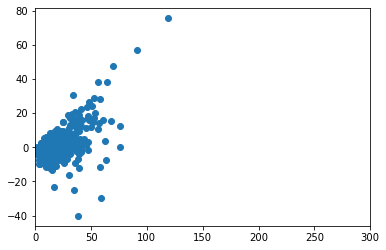

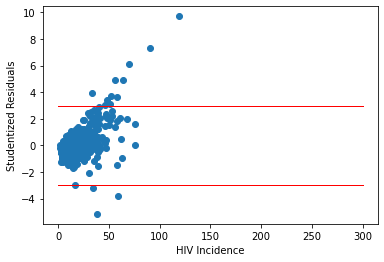

In [231]:
## ##
df = X3.copy()
df.head()
print(df.shape)
xx = np.linspace(0,300, 100)

df["y_hat"] = model.predict(X3)
df["Residuals"] = y - df["y_hat"]
# Plot the line along with the data
fig, ax = plt.subplots()
ax.scatter(y, df['Residuals'])
plt.savefig('Residuals')

#ax.plot(xx, [0]*, color='red', lw=3)
_ = ax.set_xlim([0,300])
fig, ax = plt.subplots()
est_std = np.std(df['Residuals'])
print("Estimated standard error: ", est_std)
df['Studentized Res.'] = df['Residuals']/est_std

ax.scatter(y, df['Studentized Res.'])
ax.plot(xx, [3]*100, color='red', lw=1)
ax.plot(xx, [-3]*100, color='red', lw=1)
ax.set_xlabel('HIV Incidence')
ax.set_ylabel('Studentized Residuals')
plt.savefig('Studentized Residuals')

In [232]:
from sklearn.dummy import DummyRegressor
dummy_regr = DummyRegressor()
dummy_regr.fit(X_train, y_train)
DummyRegressor()
dummy_regr.predict(X_test)
print(dummy_regr.score(X_test, y_test))

-0.0011473475514862663
